In [2]:
import numpy as np

In [67]:
class Investment:

    def __init__(self, invested, round):
        self.invested = invested
        self.round = round
        self.shares = np.round(self.invested / self.round.price,6)
        self.share_type = self.round.share_type

class Investor:

    def __init__(self, name):
        self.name = name
        self.investments = []

    def new_investment(self, invested, round):
        investment = Investment(invested, round)
        self.investments.append(investment)

    def total_shares(self):
        shares = 0
        for i in self.investments: 
            shares += i.shares 
        return shares

    def shares_ownership(self):
        stake = {}
        for i in self.investments:
            if i.share_type in stake.keys():
                stake[i.share_type] += i.shares
            else:
                stake[i.share_type] = i.shares
        return stake
    
    def total_invested(self):
        invested = 0
        for i in self.investments:
            invested += i.invested 
        return invested

class Covenants:
    
    def __init__(self, covenants={}):
        self.liquidity_preference = covenants.get('liquidity_preference', 0)
           
class Round:

    def __init__(self, name, invested, valuation, total_shares, new_shares, type, covenants):
        self.name = name
        self.invested = invested
        self.valuation = valuation
        self.new_shares = new_shares
        self.share_type = type if type != 'common' else '_common'
        self.price = round(valuation/total_shares,6)
        self.covenants = covenants

class BookInvestor:
    def __init__(self, name, stake):
        self.name = name
        self.stake = np.round(stake / 100,4)

class Deal:

    def __init__(self, investment, stake, share_type):
        self.investment = investment
        self.stake = np.round(stake / 100,4)
        self.share_type = share_type
        self.book = []

    def add_investor(self, investor):
        self.book.append(investor)

class Company:
    
    def __init__(self, name, equity, shares):
        self.name = name

        self.incorporation = Round('incorporation', equity, equity, shares, shares, 'common', Covenants())

        self.founder = Investor('founder')
        self.founder.new_investment(equity, self.incorporation)

        self.investors = [self.founder]
        self.rounds = [self.incorporation]

    def current_stake(self):
        cap = {}
        for i in self.investors:
            last_round = self.rounds[-1]
            total_shares = self.total_shares()
            investor_shares = i.total_shares()
            cap[i.name] = {
                'stake': np.round(investor_shares / total_shares * 100, 2)
            }
        return cap
    
    def shares_ownership(self):
        aux = {}
        for i, r in enumerate(self.rounds[::-1]):
            if r.share_type not in aux.keys(): 
                aux[r.share_type] = {'shares': r.new_shares, 'invested': r.invested, 'investors': {}, 'liquidity_preference_due': 0}
            else:
                aux[r.share_type]['shares'] += r.new_shares
                aux[r.share_type]['invested'] += r.invested

        for i in self.investors:
            for a in i.investments:
                if a.share_type in aux.keys():
                    if i.name not in aux[a.share_type]['investors'].keys():
                        aux[a.share_type]['investors'][i.name] = {
                            'invested': a.invested,
                            'shares': a.shares,
                            'company_stake': np.round(a.shares/ self.total_shares(),2),
                            'share_type_stake': np.round(a.shares/aux[a.share_type]['shares'],2),
                            'liquidity_preference_due': np.round(a.invested * a.round.covenants.liquidity_preference,2),
                        }
                    else:
                        aux[a.share_type]['investors'][i.name]['invested'] += a.invested
                        aux[a.share_type]['investors'][i.name]['shares'] += a.shares
                        aux[a.share_type]['investors'][i.name]['company_stake'] = np.round(aux[a.share_type]['investors'][i.name]['shares'] / self.total_shares(),2)
                        aux[a.share_type]['investors'][i.name]['share_type_stake'] = np.round(aux[a.share_type]['investors'][i.name]['shares']/aux[a.share_type]['shares'],2)
                        aux[a.share_type]['investors'][i.name]['liquidity_preference_due'] += np.round(a.invested * a.round.covenants.liquidity_preference,2)
                    aux[a.share_type]['liquidity_preference_due'] += np.round(a.invested * a.round.covenants.liquidity_preference,2)
        return sorted(aux.items(), reverse=True)

    def get_investor(self, name):
        for i in self.investors:
            if name == i.name:
                return i
        return None

    def add_investor(self, name):
        new_investor = Investor(name)
        self.investors.append(new_investor)
        return new_investor

    def get__or_add_investor(self, name):
        investor = self.get_investor(name)
        if investor is None:
            investor = self.add_investor(name)
        return investor

    def total_shares(self):
        return sum(r.new_shares for r in self.rounds)

    def last_valuation(self):
        return self.rounds[-1].valuation

    def new_round(self, name, deal, covenants):

        
        post_money_valuation = deal.investment / deal.stake
        pre_money_valuation = post_money_valuation -  deal.investment
        
        old_shares = self.total_shares()
        new_shares =  old_shares * deal.investment / pre_money_valuation
        
        round = Round(name, deal.investment, post_money_valuation, old_shares+new_shares , new_shares, deal.share_type, covenants = covenants)
        
        self.rounds.append(round)

        for i in deal.book:
            new_investor = self.get__or_add_investor(i.name)
            new_investor.new_investment(deal.investment * i.stake , round)
            
        return None
    
    def exit(self, valuation):
        investors = self.current_stake()
        val_to_dist = valuation
        for i in self.shares_ownership():
            to_pay = np.minimum(i[-1]['liquidity_preference_due'], val_to_dist) if i[0] != '_common' else val_to_dist
            for j in i[-1]['investors'].items():
                stake_value = j[-1]['company_stake'] * valuation
                liquidity_pref_floor = np.minimum(j[-1]['liquidity_preference_due'], to_pay * j[-1]['share_type_stake']) 
                total_paid = np.minimum(np.maximum(liquidity_pref_floor, stake_value), val_to_dist)  if i[0] != '_common' else to_pay * j[-1]['share_type_stake']
                val_to_dist -= total_paid
                if 'invested' in investors[j[0]].keys():
                    investors[j[0]]['invested'] += j[-1]['invested']
                else:
                    investors[j[0]]['invested'] = j[-1]['invested']
                if 'total_paid' in investors[j[0]].keys():
                    investors[j[0]]['total_paid'] += total_paid 
                else:
                     investors[j[0]]['total_paid'] = total_paid
                if 'stake_value' in investors[j[0]].keys():
                    investors[j[0]]['stake_value'] += stake_value 
                else:
                     investors[j[0]]['stake_value'] = stake_value
                
        for i,k in enumerate(investors):
            investors[k]['liquidity_preference_value'] = investors[k]['total_paid'] - investors[k]['stake_value']
            investors[k]['MOIC'] = investors[k]['total_paid']/investors[k]['invested']
        return investors

            
        

In [68]:
capital = 1e4
price_per_share = 0.01

company = Company('consorciei', capital, capital/price_per_share)
company.incorporation.valuation

10000.0

In [69]:
cap = company.current_stake()
cap

{'founder': {'stake': 100.0}}

In [70]:
deal = Deal(10000, 10, 'common')
deal.add_investor(BookInvestor('ze', 100))
company.new_round('seed', deal, Covenants({}))

In [71]:
company.current_stake()

{'founder': {'stake': 90.0}, 'ze': {'stake': 10.0}}

In [72]:
deal = Deal(500000, 20, 'a')
deal.add_investor(BookInvestor('tera', 100))
covenants = Covenants({'liquidity_preference': 1})
company.new_round('a', deal, covenants)

In [73]:
company.current_stake()

{'founder': {'stake': 72.0}, 'ze': {'stake': 8.0}, 'tera': {'stake': 20.0}}

In [74]:
deal = Deal(1000000, 10, 'b')
deal.add_investor(BookInvestor('yc', 100))
covenants = Covenants({'liquidity_preference': 2})
company.new_round('b', deal, covenants)

In [75]:
company.current_stake()

{'founder': {'stake': 64.8},
 'ze': {'stake': 7.2},
 'tera': {'stake': 18.0},
 'yc': {'stake': 10.0}}

In [76]:
company.shares_ownership()

[('b',
  {'shares': 154320.98765432095,
   'invested': 1000000,
   'investors': {'yc': {'invested': 1000000.0,
     'shares': 154320.987654,
     'company_stake': 0.1,
     'share_type_stake': 1.0,
     'liquidity_preference_due': 2000000.0}},
   'liquidity_preference_due': 2000000.0}),
 ('a',
  {'shares': 277777.77777777775,
   'invested': 500000,
   'investors': {'tera': {'invested': 500000.0,
     'shares': 277777.777778,
     'company_stake': 0.18,
     'share_type_stake': 1.0,
     'liquidity_preference_due': 500000.0}},
   'liquidity_preference_due': 500000.0}),
 ('_common',
  {'shares': 1111111.111111111,
   'invested': 20000.0,
   'investors': {'founder': {'invested': 10000.0,
     'shares': 1000000.0,
     'company_stake': 0.65,
     'share_type_stake': 0.9,
     'liquidity_preference_due': 0.0},
    'ze': {'invested': 10000.0,
     'shares': 111111.111111,
     'company_stake': 0.07,
     'share_type_stake': 0.1,
     'liquidity_preference_due': 0.0}},
   'liquidity_preferenc

In [77]:
# sanity check
exit_multiple = 0.26
exit_valuation = company.last_valuation() * exit_multiple
val_to_dist = exit_valuation
paid_out = 0
print('exit valuation: ', exit_valuation)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for i in company.shares_ownership():
    print('share class: ', i[0] if i[0] != 'z' else 'common')
    to_pay = np.minimum(i[-1]['liquidity_preference_due'], val_to_dist) if i[0] != 'z' else val_to_dist
    # print('to_pay: ', to_pay)
    for j in i[-1]['investors'].items():
        print('   investor: ', j[0])
        # print('      company_stake: ', j[-1]['company_stake'])
        stake_value = j[-1]['company_stake'] * exit_valuation
        # print('      stake_value: ', stake_value)
        liquidity_pref_floor = np.minimum(j[-1]['liquidity_preference_due'], to_pay * j[-1]['share_type_stake']) 
        # print('      liquidity_pref_floor: ', liquidity_pref_floor)
        total_paid = np.minimum(np.maximum(liquidity_pref_floor, stake_value), val_to_dist)  if i[0] != 'z' else to_pay * j[-1]['share_type_stake']
        print('      total_paid: ', total_paid)
        print('      paid_due_to_stake: ', stake_value)
        print('      paid_due_to_pref: ', total_paid-stake_value)
        paid_out += total_paid
        val_to_dist -= total_paid
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('total paid: ', paid_out)

exit valuation:  2600000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
share class:  b
   investor:  yc
      total_paid:  2000000.0
      paid_due_to_stake:  260000.0
      paid_due_to_pref:  1740000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
share class:  a
   investor:  tera
      total_paid:  500000.0
      paid_due_to_stake:  468000.0
      paid_due_to_pref:  32000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
share class:  _common
   investor:  founder
      total_paid:  100000.0
      paid_due_to_stake:  1690000.0
      paid_due_to_pref:  -1590000.0
   investor:  ze
      total_paid:  0.0
      paid_due_to_stake:  182000.00000000003
      paid_due_to_pref:  -182000.00000000003
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
total paid:  2600000.0


In [78]:
company.exit(company.last_valuation() * exit_multiple)

{'founder': {'stake': 64.8,
  'invested': 10000.0,
  'total_paid': 90000.0,
  'stake_value': 1690000.0,
  'liquidity_preference_value': -1600000.0,
  'MOIC': 9.0},
 'ze': {'stake': 7.2,
  'invested': 10000.0,
  'total_paid': 10000.0,
  'stake_value': 182000.00000000003,
  'liquidity_preference_value': -172000.00000000003,
  'MOIC': 1.0},
 'tera': {'stake': 18.0,
  'invested': 500000.0,
  'total_paid': 500000.0,
  'stake_value': 468000.0,
  'liquidity_preference_value': 32000.0,
  'MOIC': 1.0},
 'yc': {'stake': 10.0,
  'invested': 1000000.0,
  'total_paid': 2000000.0,
  'stake_value': 260000.0,
  'liquidity_preference_value': 1740000.0,
  'MOIC': 2.0}}

In [85]:
multiple_range = np.linspace(0,3,101)
returns = {}
for m in multiple_range:
    result = company.exit(company.last_valuation() * m)
    for i in result.keys():
        if i in returns.keys():
            returns[i].append(result[i]['MOIC'])
        else:
            returns[i] = []
            returns[i].append(result[i]['MOIC'])


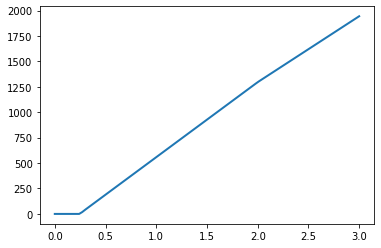

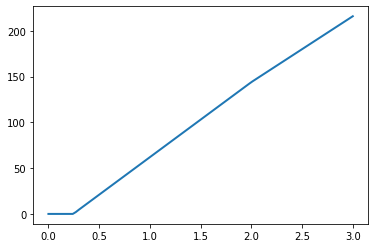

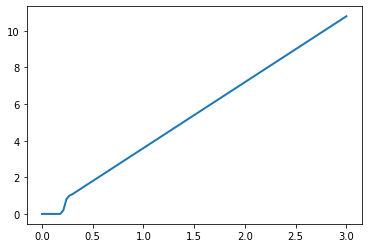

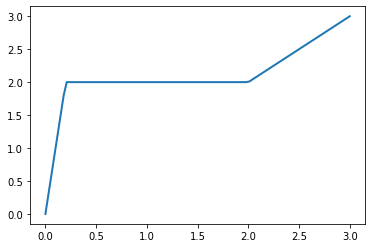

In [86]:
import matplotlib.pyplot as plt

# plot


investors = []
for i in company.investors:
    fig, ax = plt.subplots()

    ax.plot(multiple_range, returns[i.name], linewidth=2.0)

    plt.show()